In [1]:
import pandas as pd
import numpy as np

## Split into separate csv files

In [4]:
import re

def split_participant_data(filename):
    # Read the entire file
    with open(filename, 'r') as file:
        content = file.readlines()
    
    participant_data = []
    current_data = []
    recording = False
    header_line = None
    
    for line in content:
        # Check if this is a separator line (starts with ###)
        if line.strip().startswith('###'):
            # If we were recording data, save the current participant
            if recording and current_data:
                # Create DataFrame using the saved header
                df = pd.DataFrame([row.split(',') for row in current_data])
                participant_name = re.search(r'###\s+(.+?)\s+###', participant_header).group(1)
                participant_data.append((participant_name, df))
                
            # Start recording a new participant
            recording = True
            participant_header = line.strip()
            current_data = []
            header_pending = True
            
        elif recording:
            if header_pending:
                # This is the header line
                header_line = line.strip()
                header_pending = False
                current_data.append(header_line)
            else:
                # This is a data line
                current_data.append(line.strip())
    
    # Don't forget to save the last participant
    if recording and current_data:
        df = pd.DataFrame([row.split(',') for row in current_data])
        participant_name = re.search(r'###\s+(.+?)\s+###', participant_header).group(1)
        participant_data.append((participant_name, df))
    
    return participant_data

# Usage
filename = 'Normalized time series_NB.csv'
participants = split_participant_data(filename)

# Save each participant's data to a separate file
for name, df in participants:
    # Clean filename by removing characters that might not be valid in filenames
    clean_name = re.sub(r'[^\w\-]', '_', name)
    output_file = f"NB_data/{clean_name}.csv"
    
    # Set first row as column headers
    new_df = pd.DataFrame(df.values[1:], columns=df.iloc[0])
    
    # Save to CSV
    new_df.to_csv(output_file, index=False)
    print(f"Saved {output_file}")

Saved NB_data/NB01_Normalized_KneeA_csv.csv
Saved NB_data/NB02_Normalized_KneeA_csv.csv
Saved NB_data/NB03_Normalized_KneeA_csv.csv
Saved NB_data/NB04_Normalized_KneeA_csv.csv
Saved NB_data/NB05_Normalized_KneeA_csv.csv
Saved NB_data/NB06_Normalized_KneeA_csv.csv
Saved NB_data/NB07_Normalized_KneeA_csv.csv
Saved NB_data/NB08_Normalized_KneeA_csv.csv
Saved NB_data/NB09_Normalized_KneeA_csv.csv
Saved NB_data/NB10_Normalized_KneeA_csv.csv
Saved NB_data/NB11_Normalized_KneeA_csv.csv
Saved NB_data/NB12_Normalized_KneeA_csv.csv


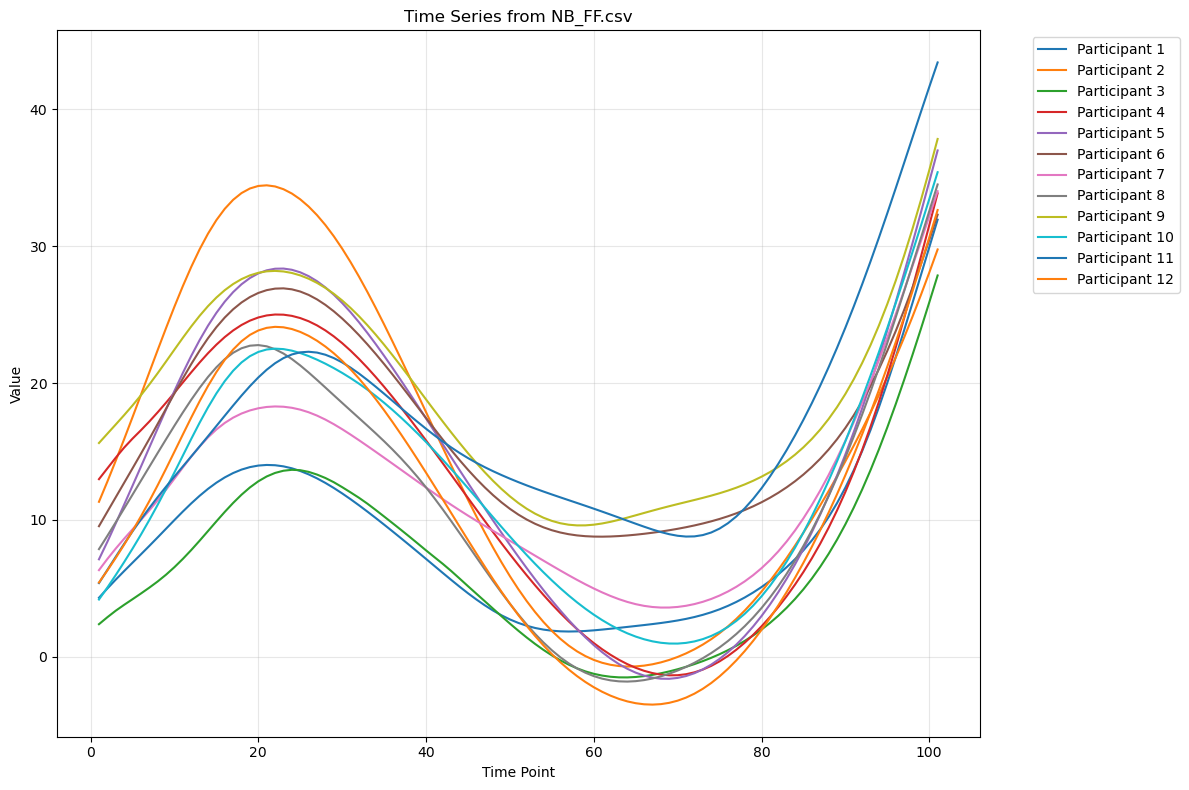

In [7]:
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('NB_FF.csv', header=None)

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create x-axis values (1 to 100)
x_values = np.arange(1, 102)

# Plot each row as a separate curve
for i in range(len(df)):
    plt.plot(x_values, df.iloc[i], label=f'Participant {i+1}')

# Add labels and title
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.title('Time Series from NB_FF.csv')

# Add a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to make room for legend
plt.tight_layout()
plt.show()

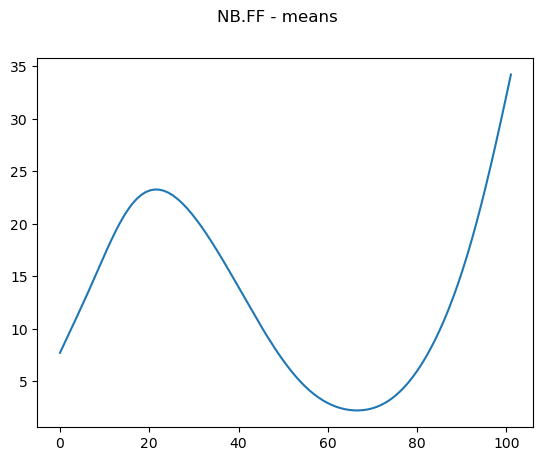

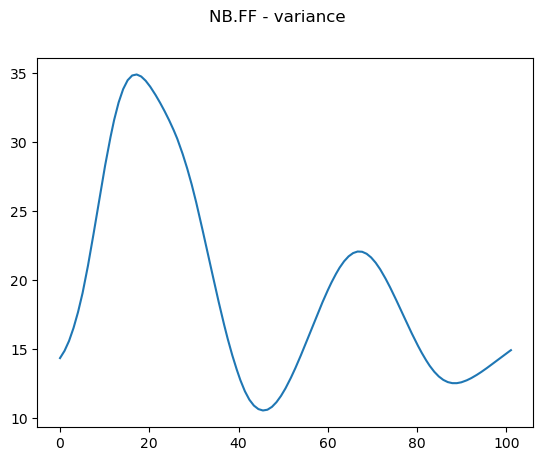

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skfda import FDataGrid
from skfda.exploratory.visualization import FPCAPlot
from skfda.exploratory.stats import mean, var


# Convert to numpy array
data_array = df.values

# Define the time points (your x-axis)
time_points = np.linspace(0, 101, 101)

# Create FDA data object
fd = FDataGrid(data_array, time_points)


# 2. Calculate mean function
mean_fd = mean(fd)

# 3. Calculate variance function
var_fd = var(fd)



# 5. Visualize results

# Mean and variance functions
mean_fd.dataset_name = "NB.FF - means"
mean_fd.plot(legend=True)
var_fd.dataset_name = "NB.FF - variance"
var_fd.plot(legend=True)

plt.show()

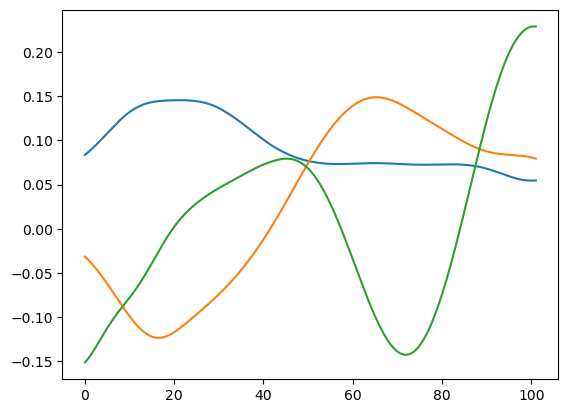

In [24]:
# FPCA visualization
# 4. Perform FPCA
from skfda.preprocessing.dim_reduction import FPCA
fpca = FPCA(n_components=3)  # Extract top 3 components
fpca.fit(fd)
fpca.components_.plot()
plt.show()

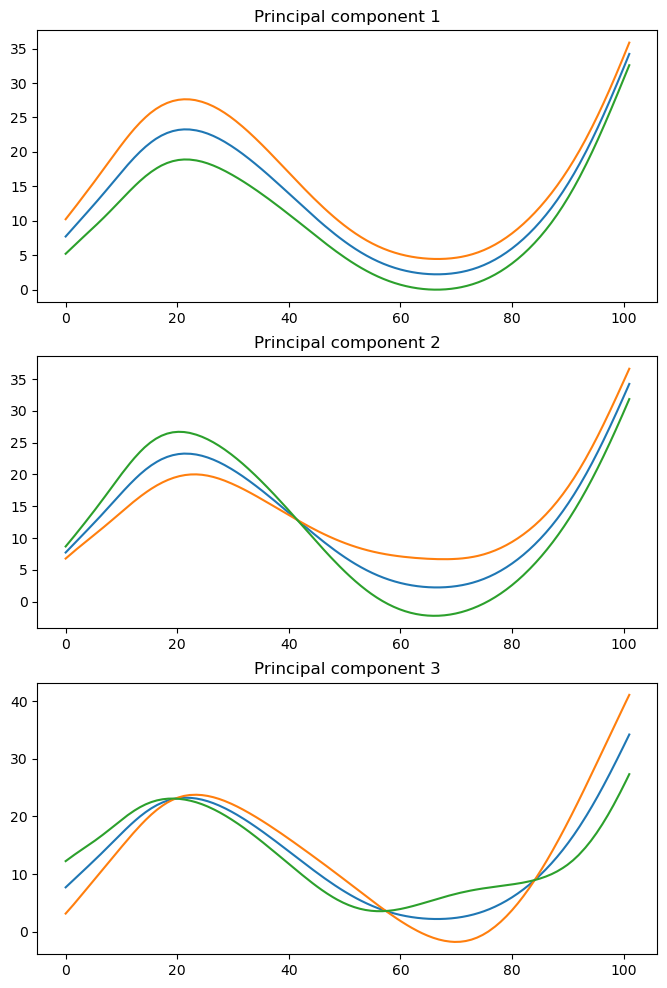

In [27]:
FPCAPlot(
    fd.mean(),
    fpca.components_,
    factor=30,
    fig=plt.figure(figsize=(8, 3 * 4)),
    n_rows=3,
).plot()
plt.show()

These plots show how each principal component affects the mean curve when added or subtracted. In each plot:
- The blue line represents the mean function
- The orange line shows mean + (factor × component)
- The green line shows mean - (factor × component)

### Principal Component 1 (Top plot)
This component primarily captures variations in the **overall magnitude** of the curves, particularly at the first peak (around time point 20-30) and the depth of the valley (around time point 60-70). Subjects with positive scores on PC1 would have higher peaks and less pronounced valleys (orange line), while those with negative scores would have lower peaks and deeper valleys (green line).

### Principal Component 2 (Middle plot)
This component captures a **phase shift or timing difference** in the first peak. Notice how the green line has an earlier and higher first peak (around time point 20), while the orange line has a later and lower first peak. This suggests that PC2 represents variation in when participants reach their maximum value during the initial movement phase.

### Principal Component 3 (Bottom plot)
This component primarily captures variations in the **middle to late section** of the curves (time points 60-90). The most notable difference is around time point 70, where the orange line goes into a deeper valley while the green line stays higher. This likely represents differences in the recovery phase of the movement.

The factor=30 means these visualizations are showing an exaggerated effect (30 times the actual component values) to make the differences more visible.

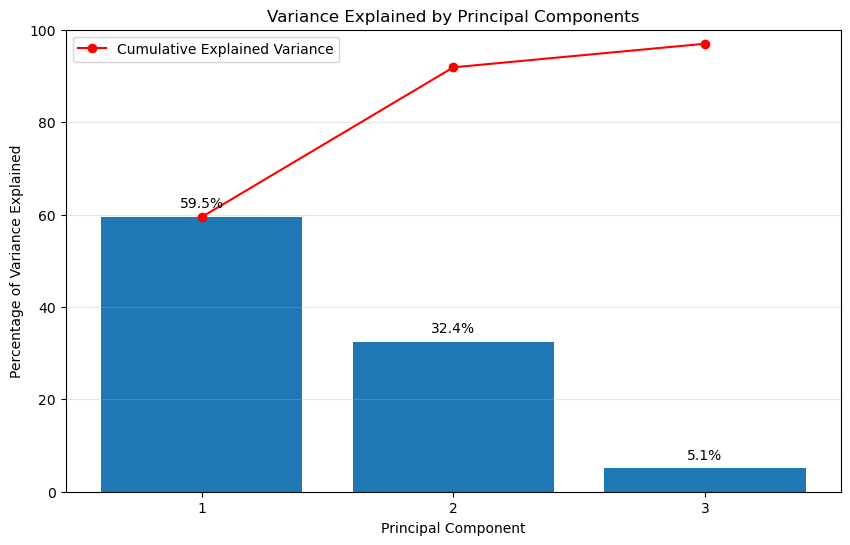

In [30]:
# Assuming fd_smooth is your smoothed functional data object
fpca = FPCA(n_components=3)
fpca.fit(fd)

# Get explained variance ratio
explained_variance_ratio = fpca.explained_variance_ratio_

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, 4), explained_variance_ratio * 100)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.xticks(range(1, 4))
plt.ylim(0, 100)

# Add numerical labels
for i, v in enumerate(explained_variance_ratio):
    plt.text(i+1, v*100 + 2, f"{v*100:.1f}%", ha='center')

# Add cumulative variance line
plt.plot(range(1, 4), np.cumsum(explained_variance_ratio) * 100, 
         'ro-', label='Cumulative Explained Variance')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [32]:
# Get scores for each participant on each component
scores = fpca.transform(fd)
# Create a table of all scores
scores_df = pd.DataFrame(scores, 
                        columns=[f"PC{i+1}" for i in range(scores.shape[1])],
                        index=[f"Participant {i+1}" for i in range(scores.shape[0])])
print(scores_df)

                      PC1        PC2        PC3
Participant 1  -50.309463  16.762055 -10.894559
Participant 2   38.262968 -43.470714  -6.662014
Participant 3  -66.501192   3.508580  -6.522439
Participant 4    3.330547 -23.149632  -0.636876
Participant 5   15.756792 -23.963336  12.805255
Participant 6   35.006065  16.588870 -13.546014
Participant 7  -15.667178  19.491953  -0.706651
Participant 8  -15.465269 -14.523353   1.820765
Participant 9   53.852320  20.783067 -12.390974
Participant 10  -5.014653   2.548270  11.797178
Participant 11  23.512837  50.015462  17.607215
Participant 12 -16.763774 -24.591222   7.329115


Individual_Curve = Mean_Curve + (PC1_Score × PC1) + (PC2_Score × PC2) + (PC3_Score × PC3)

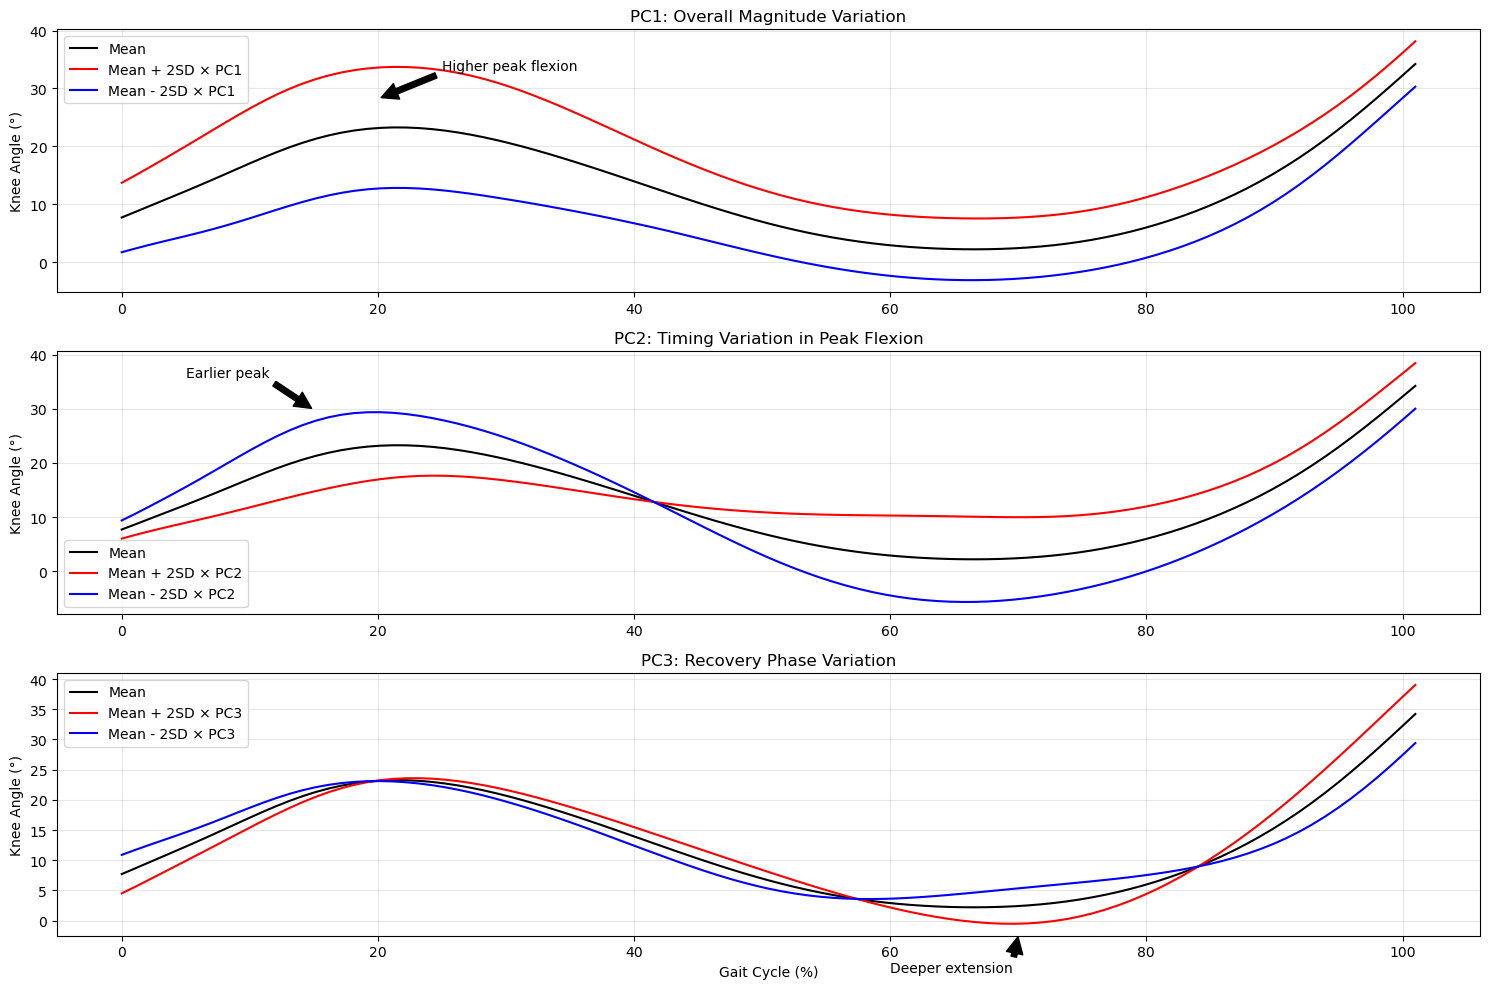

In [35]:
# Visualize mean ± component for biomechanical interpretation
plt.figure(figsize=(15, 10))

# Time points
time_points = np.linspace(0, 101, 101)

# Get the mean function and components
mean_curve = fd.mean()
pc1 = fpca.components_[0]
pc2 = fpca.components_[1]
pc3 = fpca.components_[2]

# Calculate standard deviation for scaling
std_dev = np.sqrt(fpca.explained_variance_[0])

# Plot for PC1 (interpreted as overall magnitude differences)
plt.subplot(3, 1, 1)
plt.plot(time_points, mean_curve.data_matrix[0], 'k-', label='Mean')
plt.plot(time_points, (mean_curve + 2*std_dev*pc1).data_matrix[0], 'r-', 
         label='Mean + 2SD × PC1')
plt.plot(time_points, (mean_curve - 2*std_dev*pc1).data_matrix[0], 'b-', 
         label='Mean - 2SD × PC1')
plt.title('PC1: Overall Magnitude Variation')
plt.ylabel('Knee Angle (°)')
plt.legend()
plt.grid(alpha=0.3)

# Add biomechanical interpretation
plt.annotate('Higher peak flexion', xy=(20, mean_curve.data_matrix[0][20] + 5), 
             xytext=(25, mean_curve.data_matrix[0][20] + 10),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Plot for PC2 (interpreted as timing differences)
plt.subplot(3, 1, 2)
std_dev = np.sqrt(fpca.explained_variance_[1])
plt.plot(time_points, mean_curve.data_matrix[0], 'k-', label='Mean')
plt.plot(time_points, (mean_curve + 2*std_dev*pc2).data_matrix[0], 'r-', 
         label='Mean + 2SD × PC2')
plt.plot(time_points, (mean_curve - 2*std_dev*pc2).data_matrix[0], 'b-', 
         label='Mean - 2SD × PC2')
plt.title('PC2: Timing Variation in Peak Flexion')
plt.ylabel('Knee Angle (°)')
plt.legend()
plt.grid(alpha=0.3)

# Add biomechanical interpretation
plt.annotate('Earlier peak', xy=(15, (mean_curve - 2*std_dev*pc2).data_matrix[0][15] + 2), 
             xytext=(5, (mean_curve - 2*std_dev*pc2).data_matrix[0][15] + 8),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Plot for PC3 (interpreted as recovery phase differences)
plt.subplot(3, 1, 3)
std_dev = np.sqrt(fpca.explained_variance_[2])
plt.plot(time_points, mean_curve.data_matrix[0], 'k-', label='Mean')
plt.plot(time_points, (mean_curve + 2*std_dev*pc3).data_matrix[0], 'r-', 
         label='Mean + 2SD × PC3')
plt.plot(time_points, (mean_curve - 2*std_dev*pc3).data_matrix[0], 'b-', 
         label='Mean - 2SD × PC3')
plt.title('PC3: Recovery Phase Variation')
plt.xlabel('Gait Cycle (%)')
plt.ylabel('Knee Angle (°)')
plt.legend()
plt.grid(alpha=0.3)

# Add biomechanical interpretation
plt.annotate('Deeper extension', xy=(70, (mean_curve + 2*std_dev*pc3).data_matrix[0][70] - 2), 
             xytext=(60, (mean_curve + 2*std_dev*pc3).data_matrix[0][70] - 8),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()